In [32]:
import numpy as np
from scipy.linalg import expm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.linalg import expm

def interpolate_hamiltonian(H0, Hf, t, t_total):
    return (1 - t / t_total) * H0 + (t / t_total) * Hf

def evolve_wavefunction(psi, H, dt, hbar=1.0):
    """Evolve the wavefunction by a small time step dt using the Hamiltonian H."""
    U = expm(-1j * H * dt)
    psi = np.dot(U, psi)
    return psi

def calculate_adiabatic_properties(N, M, mu, init_J, init_V, V, t_total, dt):
    n_excited_states = M**N

    initial_hamiltonian = construct_initial_hamiltonian(N, M, mu) + construct_hamiltonian(N, M, init_J, init_V)
    final_hamiltonian = construct_hamiltonian(N, M, J, V)

    times = np.linspace(0, t_total, int(t_total / dt))

    eigenvalues_0, eigenvectors_0 = exact_diagonalize(initial_hamiltonian)
    psi_0 = eigenvectors_0[0]  # Ground state of H0 (first column is the ground state)

    adiabatic_wavefunctions = [psi_0]
    true_energies = []
    adiabatic_energies = []
    overlaps_all_states = []

    psi = psi_0.copy()

    for t in times:
        instantaneous_hamiltonian = interpolate_hamiltonian(initial_hamiltonian, final_hamiltonian, t, t_total)
        
        eigenvalues, eigenvectors = exact_diagonalize(instantaneous_hamiltonian)
        true_energies.append(eigenvalues)
        
        psi = evolve_wavefunction(psi, instantaneous_hamiltonian, dt)
        psi = psi / np.linalg.norm(psi)
        
        adiabatic_wavefunctions.append(psi)
        
        adiabatic_energy = np.real(np.conj(psi).T @ instantaneous_hamiltonian @ psi)
        adiabatic_energies.append(adiabatic_energy)
        
        overlaps = [np.abs(np.conj(eigenvectors[i]).T @ psi)**2 for i in range(n_excited_states)]
        overlaps_all_states.append(overlaps)

    true_energies = np.array(true_energies)
    overlaps_all_states = np.array(overlaps_all_states)

    adiabatic_diff = adiabatic_energies - true_energies[:, 0]
    adiabatic_diff = np.array(adiabatic_diff)
    
    energy_gaps = [eigenvalues - eigenvalues[0] for eigenvalues in true_energies]
    true_energies = np.array(true_energies)
    energy_gaps = np.array(energy_gaps)
    
    return adiabatic_energies, adiabatic_diff, overlaps_all_states, true_energies, energy_gaps, times

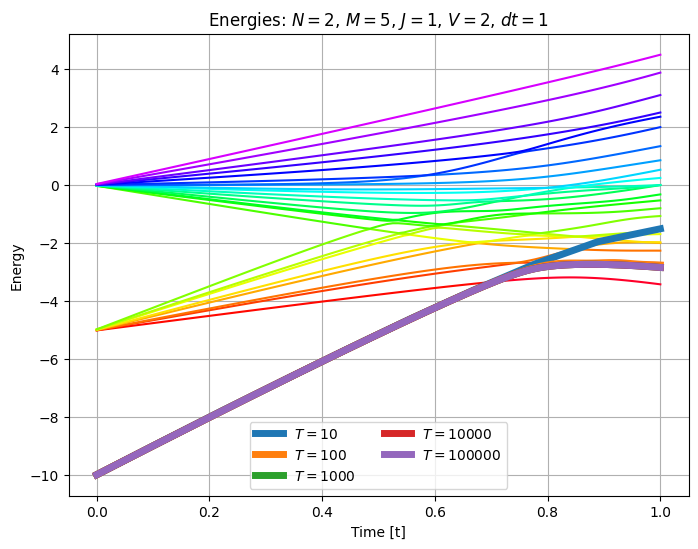

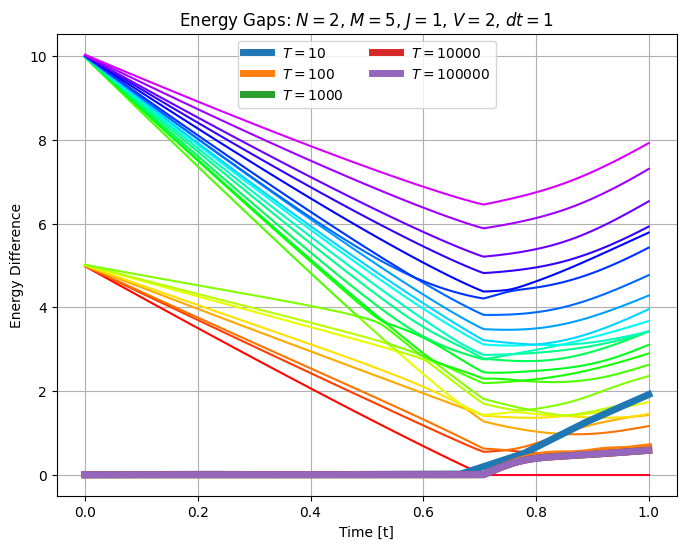

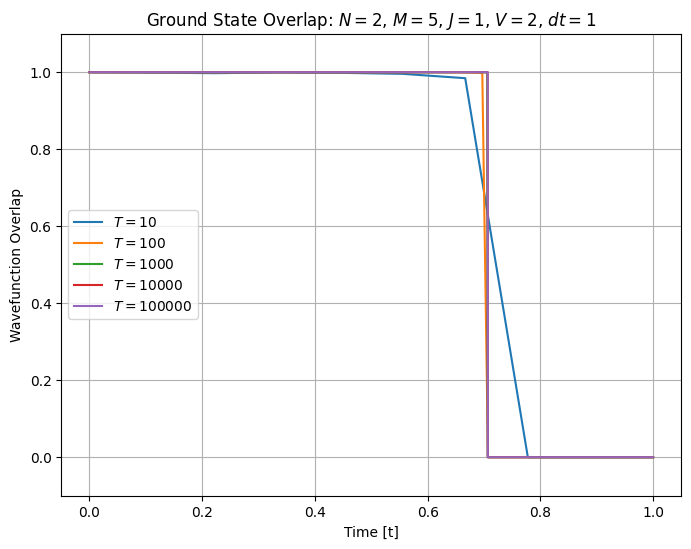

In [74]:
N = 2
M = 5

mu = 5
init_J = 0.01
init_V = 0.01

J = 1
V = 2

total_times = [10, 10e1, 10e2, 10e3, 10e4]
total_times = [int(t) for t in total_times]
dt = 1

n_excited_states = M**N

cmap = plt.get_cmap("gist_rainbow")
colors = [cmap(i / (n_excited_states + 1)) for i in range(n_excited_states + 1)]

fig, ax = plt.subplots(figsize=(8, 6))
fig2, ax2 = plt.subplots(figsize = (8,6))
fig3, ax3 = plt.subplots(figsize = (8,6))

_, _, _, true_energies, energy_gaps, times = calculate_adiabatic_properties(N, M, mu, init_J, init_V, V, 1, dt=0.01)   

for i in range(n_excited_states):
    ax.plot(times, true_energies[:, i], color=colors[i])
    
for i in range(n_excited_states):
    ax2.plot(times, energy_gaps[:, i], color=colors[i])

for t_total in total_times:
    adiabatic_energies, adiabatic_diff, overlaps_all_states, true_energies, energy_gaps, times = calculate_adiabatic_properties(N, M, mu, init_J, init_V, V, t_total, dt)   
    ax.plot(times/len(times), adiabatic_energies, linestyle="-", linewidth = 5, label=f"$T=${t_total}")
    ax2.plot(times/len(times), adiabatic_diff, linestyle="-", linewidth = 5, label=f"$T=${t_total}")
    ax3.plot(times/len(times), overlaps_all_states[:, 0], linestyle="-", label=f"$T=${t_total}")
    
ax.set_title(f"Energies: $N=${N}, $M=${M}, $J = ${J}, $V = ${V}, $dt=${np.round(dt, 3)}")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy")
ax.legend(loc="lower center", ncols = len(total_times)//2)
ax.grid(True)

ax2.set_title(f"Energy Gaps: $N=${N}, $M=${M}, $J = ${J}, $V = ${V}, $dt=${np.round(dt, 3)}")
ax2.set_xlabel("Time [t]")
ax2.set_ylabel("Energy Difference")
ax2.legend(loc="upper center", ncols = len(total_times)//2)
ax2.grid(True)

ax3.set_ylim(-0.1,1.1)
ax3.set_title(f"Ground State Overlap: $N=${N}, $M=${M}, $J = ${J}, $V = ${V}, $dt=${np.round(dt, 3)}")
ax3.set_xlabel("Time [t]")
ax3.set_ylabel("Wavefunction Overlap")
ax3.legend(loc="center left")
ax3.grid(True)